# Demonstration

We use the dataset of exo-planets for demonstration (features are in log).  
Replace `PATH_DATA` with your own dataset.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import normalization
from knnxkde import KNNxKDE

In [14]:
PATH_DATA = 'data/planets.csv'
data = pd.read_csv(PATH_DATA, header=None)
data = np.array(data.iloc[1:, :]).astype('float32')
N, d = data.shape

In [18]:
miss_mask = (np.random.uniform(size=(N, d)) < 0.2)  # hide 20% of the data completely at random
miss_data = np.copy(data)
miss_data[miss_mask] = np.nan

In [19]:
norm_miss_data, norm_params = normalization(miss_data)  # normalize the data such that each column is in [0, 1]

In [20]:
knnxkde = KNNxKDE(h=0.03, tau=1.0/50.0, metric='nan_std_eucl')  # define the kNNxKDE (here default values)

In [21]:
imputed_samples = knnxkde.impute_samples(norm_miss_data, nb_draws=1000)

### Results investigation

Now, let's look at the output of the $k$NN$\times$KDE...

In [65]:
print(type(imputed_samples))  # the kNNxKDE returns a disctionary
print('Total number of keys =', len(imputed_samples))  # with one key for each missing cell
list_keys = list(imputed_samples.keys())
list_keys.sort()
print('The first five keys are:', list_keys[:5])

<class 'dict'>
Total number of keys = 677
The first five keys are: [(1, 4), (2, 1), (2, 3), (3, 3), (4, 2)]


For each missing cell in our dataset, the $k$NN$\times$KDE returns a probability distribution.  
Let's take a look at an individual cell probability distribution.

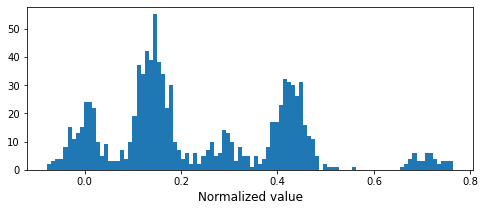

In [66]:
first_key = list_keys[0]
distrib = imputed_samples[first_key]

plt.figure(figsize=(8, 3))
plt.hist(distrib, bins=100)
plt.xlabel('Normalized value', size=12)
plt.show()

This distribution captures multi-modality if necessary.  
We can now impute the missing value using the mean, the median, the mode, or any other appropriate statistics...  
**Note:** Recall that the data has been normalized. After imputation, don't forget to re-normalize the data back into their original range!

### The $k$NN$\times$KDE returns coherent samples

Now let's look at an observation that has two or more missing values.

In [72]:
ii = np.where(np.sum(np.isnan(norm_miss_data), axis=1) >= 2)[0][0]  # ii: interesting index
print('Index:', ii)  # this is the index of the first observation with at least two missing values
print(norm_miss_data[ii])

Index: 2
[0.48217085        nan 0.40742302        nan 0.         0.5344596 ]


In [76]:
col1 = np.where(np.isnan(norm_miss_data[ii]))[0][0]  # we select the first two missing values
col2 = np.where(np.isnan(norm_miss_data[ii]))[0][1]

In [77]:
distrib1 = imputed_samples[(ii, col1)]
distrib2 = imputed_samples[(ii, col2)]

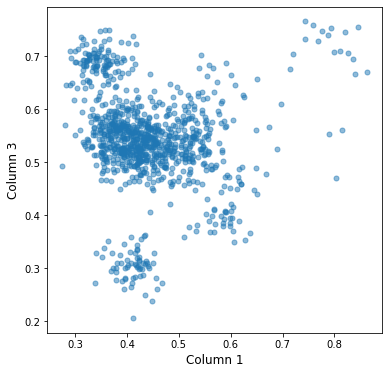

In [85]:
plt.figure(figsize=(6, 6))
plt.scatter(distrib1, distrib2, s=25, alpha=0.5)
plt.xlabel(f'Column {col1}', size=12)
plt.ylabel(f'Column {col2}', size=12)
plt.show()

On this plot, we can see that the returned samples from the $k$NN$\times$KDE are consistent with the original dataset. For a partially observed row, we can use the multivariate distribution to have a better idea of the joint distribution of each missing feature.

If row $i$ has $n$ missing values in columns $j_1, j_2, ..., j_n$, then the $k$NN$\times$KDE will return a joint distribution in dimension $n$, with entries indexed by $(i, j_1), (i, j_2), ..., (i, j_n)$ in the dictionary of imputed samples.